In [1]:
import sys
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from torch_geometric.data import Dataset, download_url, Data
import pandas as pd
import shutil
import torch
from scipy.spatial import distance

from torch_geometric import nn as gnn
import torch.nn.functional as F
from torchvision.transforms.functional import crop
from torch import nn

/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data and Hyperparams

In [2]:
with open('/home/paulraae/MS_Thesis/tester_code_files/tester_eye_data/test_eye_clusters_extract.pk1', 'rb') as handle:
    data = pickle.load(handle)

In [16]:
save_path = "/home/paulraae/MS_Thesis/tester_code_files/tester_models/conv_out_corrected_relu_addedindeconv_run_1_unet.pickle"
loss = nn.MSELoss()
epochs = 1000

In [3]:
data.keys()

dict_keys(['name', 'image', 'features', 'factor', 'cluster', 'centroids'])

In [4]:
data["features"].shape

(127, 4096)

In [5]:
class Separated_Dataset(Dataset): #For this ds I have ald done all the required pre prcessing 
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, data_dict = None, created = False):
        self.data_dict = data_dict
        self.created = created
        super().__init__(root, transform, pre_transform, pre_filter)
        
        
    @property
    def raw_file_names(self):
        return np.array([os.path.join(self.raw_dir, x) for x in self.data_dict["name"]])

    @property
    def processed_file_names(self):
        return "not_implemented.pt"
    
    def process(self):
        if self.created:
            for i in range(127):
                self.get(i)
        else:    
        
            idx = -1

            # Process pre made data dictionary

            x_features = np.append(self.data_dict["features"], self.data_dict["centroids"], axis=0)
            x_features = torch.Tensor(x_features)
            y = np.append(self.data_dict["cluster"], np.array([127,128,129,130,131]), axis=0)
            
            edge_map = []


            i=-1
            for cluster in y[:127]:
                i+=1
                edge_map.append([np.int64(i), np.int64(cluster+self.data_dict["features"].shape[0])])
                #edge_map.append([np.int64(cluster+self.data_dict["features"].shape[0]), np.int64(i)])
            

            i+=1
            for centroid1 in y[i:-1]:
                for centroid2 in y[i+1:]:
                    edge_map.append([np.int64(centroid1), np.int64(centroid2)])
                    #edge_map.append([np.int64(centroid2+self.data_dict["features"].shape[0]), np.int64(centroid1+self.data_dict["features"].shape[0])])
                i+=1

            edge_attrs = [] 


            for edge in edge_map:
                edge_attrs.append(1)
            
            edge_attrs = np.array(edge_attrs)
            edge_attrs = np.delete(edge_attrs,1)
            edge_attrs = torch.Tensor(edge_attrs)

            edge_map_aux = [None,None]
            edge_map_aux[0] = [x[0] for x in edge_map]
            edge_map_aux[1] = [x[1] for x in edge_map]
            edge_map_aux = np.array(edge_map_aux)

            y = torch.Tensor(np.array([cv2.resize(x/255.0, (256,256)) for x in self.data_dict["image"]]))

            for i in range(self.data_dict["image"].shape[0]):
                
                
                y_temp = y[i]

                x_in_feat = torch.Tensor(self.data_dict["features"][i])


                edge_map_aux_temp = np.delete(edge_map_aux,i, axis = 1)


                data = Data({"graph":x_features, "features":x_in_feat}, torch.Tensor(edge_map_aux_temp).to(int), edge_attrs, y_temp)

                torch.save(data, os.path.join(self.processed_dir, f'data_{i}.pt'))

    def len(self):
        return self.data_dict["name"].shape[0]

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [6]:
root_path = "/home/paulraae/MS_Thesis/tester_code_files/tester_eye_data/separated_training_set"
dataset = Separated_Dataset(root_path, data_dict=data, created=False)

Processing...
Done!


In [31]:
class Net(torch.nn.Module):
    def __init__(self, num_nodes, f_len):
        super().__init__()
        self.n = num_nodes
        self.f_len = f_len

        self.graph_enc_layer_1_1 = gnn.GraphConv(f_len, f_len)
        self.graph_enc_layer_1_2 = gnn.GraphConv(f_len, f_len)
        self.graph_enc_layer_2_1 = gnn.GraphConv(f_len, int(f_len/4))
        self.graph_enc_layer_2_2 = gnn.GraphConv(int(f_len/4), int(f_len/4))
        self.graph_enc_layer_3_1 = gnn.GraphConv(int(f_len/4), int(f_len/16))
        self.graph_enc_layer_3_2 = gnn.GraphConv(int(f_len/16), int(f_len/16))

        self.relu = nn.ReLU()
        self.conv_enc_pool = nn.MaxPool2d(2,2,0)
        
        self.conv_enc_1 = nn.Conv2d(1, int(self.n * 0.5), 3, 1, 1)
        self.conv_enc_1_1 = nn.Conv2d(int(self.n * 0.5), int(self.n * 0.5), 3, 1, 1)
        self.conv_enc_1_2 = nn.Conv2d(int(self.n * 0.5), int(self.n * 0.5), 3, 1, 1)
        
        self.conv_enc_2 = nn.Conv2d(int(self.n * 1.5), int(self.n*2), 3, 1, 1)
        self.conv_enc_2_1 = nn.Conv2d(int(self.n * 2), int(self.n*2), 3, 1, 1)
        self.conv_enc_2_2 = nn.Conv2d(int(self.n * 2), int(self.n*2), 3, 1, 1)
        
        self.conv_enc_3 = nn.Conv2d(int(self.n * 3), int(self.n*3.5), 3, 1, 1)
        self.conv_enc_3_1 = nn.Conv2d(int(self.n * 3.5), int(self.n*3.5), 3, 1, 1)
        self.conv_enc_3_2 = nn.Conv2d(int(self.n * 3.5), int(self.n*3.5), 3, 1, 1)
        
        self.conv_enc_4 = nn.Conv2d(int(self.n * 4.5), int(self.n*5), 3, 1, 1)

        self.conv_enc_4_1 = nn.Conv2d(int(self.n * 5), int(self.n*5), 3, 1, 1) # - Latent Space

        self.conv_enc_4_2 = nn.Conv2d(int(self.n * 5), int(self.n*5), 3, 1, 1) 

        self.deconv_4 = nn.ConvTranspose2d(int(self.n*5),int(self.n * 4.5), 2,2,0)
        self.conv_dec_4 = nn.Conv2d(int(self.n * 9), int(self.n*4.5), 3, 1, 1)
        self.conv_dec_4_1 = nn.Conv2d(int(self.n * 4.5), int(self.n*4.5), 3, 1, 1)

        self.deconv_3 = nn.ConvTranspose2d(int(self.n * 4.5),int(self.n * 3), 2,2,0)
        self.conv_dec_3 = nn.Conv2d(int(self.n * 6), int(self.n*3), 3, 1, 1)
        self.conv_dec_3_1 = nn.Conv2d(int(self.n * 3), int(self.n*3), 3, 1, 1)

        self.deconv_2 = nn.ConvTranspose2d(int(self.n*3),int(self.n * 1.5), 2,2,0)
        self.conv_dec_2 = nn.Conv2d(int(self.n * 3), int(self.n*1.5), 3, 1, 1)
        self.conv_dec_2_1 = nn.Conv2d(int(self.n * 1.5), int(self.n*1.5), 3, 1, 1)

        self.deconv_1 = nn.ConvTranspose2d(int(self.n*1.5),int(self.n), 2,2,0)
        self.conv_dec_1 = nn.Conv2d(int(self.n), int(self.n*0.5), 3, 1, 1)
        self.conv_dec_1_1 = nn.Conv2d(int(self.n*0.5), int(self.n*0.5), 3, 1, 1)

        self.deconv_out = nn.ConvTranspose2d(int(self.n*0.5),int(3), 2,2,0)
        self.conv_out = nn.Conv2d(3, 3, 1, 1, 0)



    def forward(self, nodes, edge_index, x, y=None):

        g = self.graph_enc_layer_1_1(nodes, edge_index)
        g = self.relu(g)
        g = self.graph_enc_layer_1_2(g, edge_index)
        g1 = g.reshape((int(self.n), 64, 64))
        g = self.relu(g)

        g = self.graph_enc_layer_2_1(g, edge_index)
        g = self.relu(g)
        g = self.graph_enc_layer_2_2(g, edge_index)
        g2 = g.reshape((int(self.n), 32, 32))
        g = self.relu(g)

        g = self.graph_enc_layer_3_1(g, edge_index)
        g = self.relu(g)
        g = self.graph_enc_layer_3_2(g, edge_index)
        g3 = g.reshape((int(self.n), 16, 16))

        x = self.conv_enc_1(x)
        x = self.relu(x)
        x = self.conv_enc_1_1(x)
        x = self.relu(x)
        x = self.conv_enc_1_2(x)
        x = self.relu(x)
        
        x1 = torch.cat((x,g1))
        x = self.conv_enc_pool(x1)

        x = self.conv_enc_2(x)
        x = self.relu(x)
        x = self.conv_enc_2_1(x)
        x = self.relu(x)
        x = self.conv_enc_2_2(x)
        x = self.relu(x)
        
        x2 = torch.cat((x,g2))
        x = self.conv_enc_pool(x2)

        x = self.conv_enc_3(x)
        x = self.relu(x)
        x = self.conv_enc_3_1(x)
        x = self.relu(x)
        x = self.conv_enc_3_2(x)
        x = self.relu(x)
        x3 = torch.cat((x,g3))
        x = self.conv_enc_pool(x3)

        x = self.conv_enc_4(x)
        x = self.relu(x)
        x4 = x

        x = self.conv_enc_4_1(x)
        x = self.relu(x)
        x = self.conv_enc_4_2(x)
        x = self.relu(x)

        x = self.deconv_4(x)
        x = torch.cat((x,x3))
        x = self.conv_dec_4(x)
        x = self.relu(x)
        x = self.conv_dec_4_1(x)
        x = self.relu(x)

        x = self.deconv_3(x)
        x = torch.cat((x,x2))
        x = self.conv_dec_3(x)
        x = self.relu(x)
        x = self.conv_dec_3_1(x)
        x = self.relu(x)
        
        x = self.deconv_2(x)
        x = torch.cat((x,x1))
        x = self.conv_dec_2(x)
        x = self.relu(x)
        x = self.conv_dec_2_1(x)
        x = self.relu(x)

        x = self.deconv_1(x)
        x = self.conv_dec_1(x)
        x = self.relu(x)
        x = self.conv_dec_1_1(x)
        x = self.relu(x)
        x = self.deconv_out(x)
        x = self.conv_out(x)
        
        
        return x

In [21]:
model = Net(132, 4096).to("cuda:0")
print(model)

Net(
  (graph_enc_layer_1_1): GraphConv(4096, 4096)
  (graph_enc_layer_1_2): GraphConv(4096, 4096)
  (graph_enc_layer_2_1): GraphConv(4096, 1024)
  (graph_enc_layer_2_2): GraphConv(1024, 1024)
  (graph_enc_layer_3_1): GraphConv(1024, 256)
  (graph_enc_layer_3_2): GraphConv(256, 256)
  (relu): ReLU()
  (conv_enc_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_enc_1): Conv2d(1, 66, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_enc_1_1): Conv2d(66, 66, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_enc_1_2): Conv2d(66, 66, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_enc_2): Conv2d(198, 264, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_enc_2_1): Conv2d(264, 264, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_enc_2_2): Conv2d(264, 264, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_enc_3): Conv2d(396, 462, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_enc_3_1)

# Makesure model functions as intended

In [185]:
with torch.no_grad():
    test_graph = dataset[0].x["graph"]
    test_graph = test_graph.to("cuda:0")

    test_edges = dataset[0].edge_index
    test_edges = test_edges.to("cuda:0")

    test_feats = torch.rand(1,64,64).to("cuda:0")

    out = model.forward(test_graph, test_edges, test_feats)

    del test_graph
    del test_edges
    del test_feats

In [186]:
out.shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6996838..0.418437].


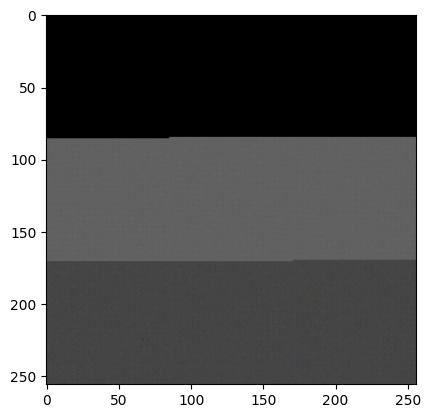

In [187]:
plt.imshow(out.reshape(256,256,3).cpu().detach().numpy())
plt.show()

In [23]:
dataset[0].y.shape

torch.Size([256, 256, 3])

In [10]:
dataset[0].y.shape

torch.Size([256, 256, 3])

# Sample Testing

In [24]:
n=-1

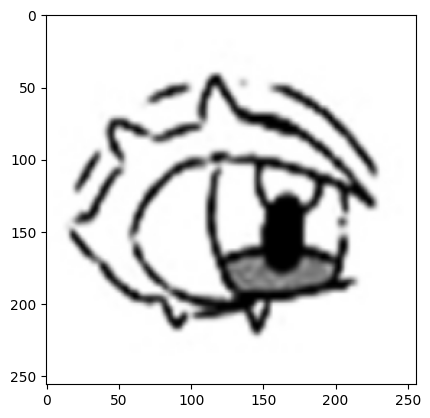

In [29]:
n+=1
plt.imshow(dataset[n].y)
plt.show()

In [22]:
save_path = "/home/paulraae/MS_Thesis/tester_code_files/tester_models/conv_out_corrected_relu_addedindeconv_run_1_unet.pickle"
model = Net(132, 4096).to("cuda:0")
model.load_state_dict(torch.load(save_path, weights_only=True))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41286403..1.1800845].


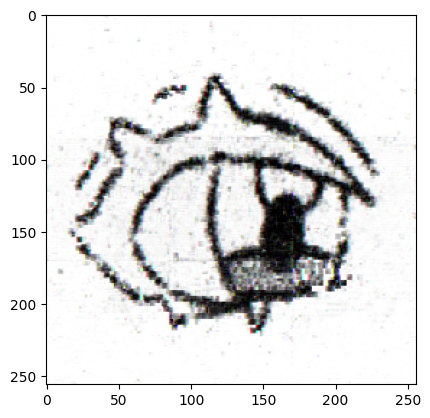

In [30]:
model.eval()
with torch.no_grad():
    test_graph = dataset[n].x["graph"]
    test_graph = test_graph.to("cuda:0")

    test_edges = dataset[n].edge_index
    test_edges = test_edges.to("cuda:0")

    test_feats = dataset[n].x["features"].reshape(1,64,64)
    test_feats = test_feats.to("cuda:0")


    out = model.forward(test_graph, test_edges, test_feats)

    del test_graph
    del test_edges
    del test_feats

plt.imshow(out.reshape(256,256,3).cpu().detach().numpy())
plt.show()

In [169]:
loss(out.reshape(256,256,3).cpu().detach(), dataset[n].y)

tensor(0.1615)

# Model Training

In [ ]:
#model = Net(132, 4096).to("cuda:0")
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

best = [0, np.Inf]

In [20]:
#Training loop for model
def train_step(model, optimizer, x, edge_index, y, loss_func=nn.MSELoss()):

    #Training loop step as defined for Pytorch models
    optimizer.zero_grad()

    pred = model.forward(x["graph"], edge_index, x["features"].reshape(1,64,64))
    pred = pred.reshape(256,256,3)
    del x["graph"]
    del x["features"]
    del edge_index
    loss = loss_func(pred, y)
    del y
    loss.backward()
    optimizer.step()

    return float(loss.detach())



loss_dict = {"train":[], "valid":[]}

for epoch in range(epochs):
        run_loss = 0.0

        model.train(True)

        #Set up mini batches as slices of dataset
        #ind = np.array([i for i in range(b["x"].shape[0])])
        #np.random.shuffle(ind)
        

        #x_batch = x_batch.to("cuda")
        #y_batch = y_batch.to("cuda")
        ind = np.array([i for i in range(len(dataset))])
        np.random.shuffle(ind)
        for sample in ind:
          
          
          x = dataset[sample].x
          y = dataset[sample].y
          edge = dataset[sample].edge_index
          
          x["graph"]=x["graph"].to("cuda:0")
          x["features"]=x["features"].to("cuda:0")
          y=y.to("cuda:0")
          edge=edge.to("cuda:0")
          
          run_loss += train_step(model, optimizer, x, edge, y, loss)

        loss_dict["train"].append(run_loss/len(dataset))

        #Epoch level evaluation
        """
        model.eval()
        with torch.no_grad():
            run_val_loss = 0.0
            f1_avg = 0.0

            for slice in ind.reshape([15,200]):
              xv_batch = v["x"][slice]
              yv_batch = v["y"][slice]

              xv_batch = xv_batch.to("cuda")
              yv_batch = yv_batch.to("cuda")

              valid = model.forward(xv_batch)

              del xv_batch

              val_acc = loss(valid, yv_batch)
              run_val_loss += float(val_acc.detach())

              f1 = metrics.MulticlassF1Score()
              f1.update(valid, yv_batch)

              del yv_batch

              f1_score = f1.compute()
              f1_avg += f1_score


            loss_dict["valid"].append(np.round(run_val_loss/15,3))
            f1_score  = f1_avg/15
          """

        print(str(epoch), " - Avg train loss:", str(run_loss/len(dataset)))

        if best[1] > run_loss:
          best[1] = run_loss
          best[0] = epoch
          torch.save(model.state_dict(), save_path)



0  - Avg train loss: 0.009142801363578461
1  - Avg train loss: 0.008757974571130407
2  - Avg train loss: 0.008997065642129952
3  - Avg train loss: 0.008752855301768643
4  - Avg train loss: 0.008605695120608948
5  - Avg train loss: 0.008721785839852385
6  - Avg train loss: 0.008843382662822178
7  - Avg train loss: 0.00885714402451642
8  - Avg train loss: 0.008571295489329757
9  - Avg train loss: 0.008391653051907857
10  - Avg train loss: 0.00836733405250968
11  - Avg train loss: 0.00820690885142196
12  - Avg train loss: 0.008208352262080889
13  - Avg train loss: 0.008195458596029619
14  - Avg train loss: 0.008301116291462905
15  - Avg train loss: 0.008274678192211418
16  - Avg train loss: 0.008295870151400096
17  - Avg train loss: 0.008154375804954862
18  - Avg train loss: 0.007910902373580716
19  - Avg train loss: 0.007612768533148282
20  - Avg train loss: 0.007569718187469549
21  - Avg train loss: 0.007966394708528527
22  - Avg train loss: 0.00806819485119126
23  - Avg train loss: 0.0

KeyboardInterrupt: 